# Locality Sensitive Hashing 局部敏感哈希

这本笔记是关于局部敏感哈希的教程和python实现。

我们使用一个非常非常小的数据集来演示这些工具，包括从CNN中抽取的4篇文章，以及其中3篇文章的部分串联的第5篇文章，来人为地产生一些高相似度分数。

由于这是一个小的数据集，我们可以很容易地将我们的近似值与文本文件之间的真实相似性分数进行比较。我们自始至终都是这样做的。本笔记本的布局如下。

第一部分：计算文本文件之间的相似性

1. 引入一个 shingle 函数。将每个文本文件清理并分割成一个 K-shingle 集合
2. 计算所有配对之间准确的 Jaccard 相似度（交集除以并集）。
3. 创建并应用一个 MinHashing 类。
    1. 用一个键值对的字典来初始化 shingles
    2. 应用“通用哈希”来对一个shingle集合进行 minhashing 操作
    3. 可以像一个函数一样被调用，以计算一个 **signature matrix**
4. 通过计算所有配对的分数来评估 MinHashing 的有效性
5. 引入LSH来寻找**候选对**，即使用 banded signature matrix 来寻找所有相似度可能高于阈值的配对
6. 通过使用哈希表的 band、列 id，使其高效，允许 O(n) 比较。

第二部分：计算向量之间的相似性

* 之后，我们为欧氏空间提供了一个额外的LSH族，即余弦相似度。
* 这是用来确定D维空间中向量的相似性。
* 可以用*随机超平面*哈希法来实现。

In [1]:
import os
import time
import itertools
import collections
import numpy as np
import matplotlib.pyplot as plt

# Part I: 文档相似度

## MinHashing 不包含 Locality Sensitive Hashing

### 1. Shingling

我们说明如何将一个 word 文档转换为 shingles 列表。
我们将使用三个相似的字符串，看看这如何显示相似性。
我做了一个目录，从 CNN 复制了4个文件，然后第5个文件是其中3个文件的串联，随机删除一些行

In [2]:
import os
HOME = os.getcwd()
TARGET = os.path.join(HOME, 'sampledocs/')

documents = []
for article in os.listdir(TARGET):
    if article == 'stopwords':
        continue
    path = os.path.join(TARGET, article)
    with open(path, 'r') as file:
        documents.append(file.read())
        
stopwords = []
with open(os.path.join(TARGET, 'stopwords'), 'r') as file:
    for line in file:
        stopwords.append(line.strip())
        
for i, doc in enumerate(documents):
    doc = doc.strip().replace('\n', ' ').lower()
    for word in stopwords:
        doc = doc.replace(' '+word+' ', ' ')
    documents[i] = doc

print(f"Average char-length: \
{np.mean(np.array([len(x) for x in documents]))}")
print(f"Min char-length: {min(len(x) for x in documents)}")
print(f"Max char-length: {max(len(x) for x in documents)}")

Average char-length: 3651.6
Min char-length: 2412
Max char-length: 5873


In [3]:
# create K-shingles by sliding window approach
def getShingles(str1, K=5):
    d1 = set()
    for i in range(len(str1)-K):
        d1.add(str1[i:i+K])
    print(f"Found {len(d1)} unique shingles, out of {len(str1)} possible.")
    return d1
doc_shingles = [getShingles(s, 5) for s in documents]

Found 2060 unique shingles, out of 3009 possible.
Found 1918 unique shingles, out of 2412 possible.
Found 2782 unique shingles, out of 3673 possible.
Found 2091 unique shingles, out of 3291 possible.
Found 3953 unique shingles, out of 5873 possible.


### 2. 定义 Jaccard 相似度（交集除以并集）

In [4]:
def jaccardSim(d1,d2):
    return len(d1.intersection(d2))/len(d1.union(d2))

# itertools.combinations finds all (,n) n-pairs
# then we use a map op on the tuples with jaccardSim
pairs = itertools.combinations(documents, 2)
pair_labels = []
pair_sims = []
for x1, x2 in itertools.combinations(zip(range(len(doc_shingles)),doc_shingles), 2):
    pair_labels.append((x1[0],x2[0]))
    pair_sims.append(jaccardSim(x1[1],x2[1]))
    
print(f"**~~~~~~ True similarity scores ~~~~~~**")
print("Pair\tScore")
print("-"*14)
for pair, score in zip(pair_labels, pair_sims):
    print(f"{pair}\t{score:.3f}")

**~~~~~~ True similarity scores ~~~~~~**
Pair	Score
--------------
(0, 1)	0.050
(0, 2)	0.069
(0, 3)	0.093
(0, 4)	0.336
(1, 2)	0.052
(1, 3)	0.051
(1, 4)	0.400
(2, 3)	0.081
(2, 4)	0.083
(3, 4)	0.294


In [5]:
# Take union of all sets. Convert to an array and assign
# each element an integer based on position in array
fullset = set.union(*doc_shingles)
shingle_dict = dict(zip(list(fullset),range(len(fullset))))
print(f"There are {len(shingle_dict)} shingles")

There are 7534 shingles


In [6]:
# shingle_dict

### 3. 定义 MinHash 类，能够创建一个 signature matrix

注意：这只接受集合作为输入（而不是矩阵），使我们能够有效地处理稀疏矩阵。

In [7]:
# Create a hash function
# define as a callable class, so that we only
# intialize random functions once
class HashManager():
    def __init__(self, shingle_dict):
        self.shingle_dict = shingle_dict
        self.N = len(shingle_dict)
        self.params = None
        
    def _initParams(self, n_sig):
        self.params = np.random.randint(self.N, size=[n_sig,2])
    
    def _permuteRow(self, row):
        return (self.params@np.array([1,row]))%self.N
    
    def __call__(self, docs, n_sig, init=True):
        # Initialize if we change signature matrix length
        # or if we request to re-initialize
        if self.params is None or len(self.params) != n_sig or init:
            self._initParams(n_sig)
            
        #initialize signature matrix
        sig = np.full((n_sig, len(docs)), np.inf)
        
        # each doc in docs is assumed to be an iterable object
        for j, doc in enumerate(docs):
            for shingle in doc:
                orig_row = shingle_dict[shingle]
                curr_col = self._permuteRow(orig_row)
                sig[:,j] = np.minimum(sig[:,j],curr_col)
        return sig.astype(int)
    
# run some tests:
try:
    print("Initialization test: ", end="")
    hm = HashManager(shingle_dict)
    print("passed")

    print("Set parameters to right size: ", end="")
    hm._initParams(n_sig=4)
    assert(hm.params.shape == (4,2))
    print("passed")

    print("Permuting a row integer returns array: ", end="")
    curr_col = hm._permuteRow(3)
    assert(curr_col.shape == (4,))
    print("passed")

    print("Compute minhashed signature matrix: ", end="")
    hm(doc_shingles, 4)
    print("passed")
except Exception as e:
    print("failure")
    print(e.args)

Initialization test: passed
Set parameters to right size: passed
Permuting a row integer returns array: passed
Compute minhashed signature matrix: passed


In [8]:
hm = HashManager(shingle_dict)

### 4. 使用MinHashing来计算相似度分数，看看它的表现如何

In [9]:
def trueSimScores(doc_shingles):
    pair_labels = []
    pair_sims = []
    idxs = range(len(doc_shingles))
    for x1, x2 in itertools.combinations(zip(idxs,doc_shingles), 2):
        pair_labels.append((x1[0], x2[0]))
        pair_sims.append(jaccardSim(x1[1], x2[1]))
    return dict(zip(pair_labels, pair_sims))
    
def sigSimScores(sig_mat):
#     cols = [sig_mat[:,i] for i in range(sig_mat.shape[1])]
    cols = sig_mat.T
    idxs = range(sig_mat.shape[1])
    
    pair_labels = []
    pair_sims = []
    for (i,col1), (j,col2) in itertools.combinations(zip(idxs, cols),2):
        pair_labels.append((i,j))
        pair_sims.append(np.mean(col1==col2))
    
    return dict(zip(pair_labels, pair_sims))

def printScoreComparison(true_dict, approx_dict):
    print(f"**~~~~~~ Similarity score comparison ~~~~~~**")
    print("Pair\t\tApprox\t\tTrue\t\t%Error")
    for pair, true_value in true_dict.items():
        approx_value = approx_dict[pair]
        err = 100*abs(true_value-approx_value)/true_value
        print(f"{pair}\t\t{approx_value:.3f}\t\t{true_value:.3f}\t\t{err:.2f}")

def candidatePairs(score_dict, threshold):
    return set(pair for pair, scr in score_dict.items() if scr>=threshold)

def accMatrix(true_dict, approx_dict, threshold):
    true_pairs = candidatePairs(true_dict, threshold)
    approx_pairs = candidatePairs(approx_dict, threshold)
    false_negatives = len(true_pairs - approx_pairs)
    false_positives = len(approx_pairs - true_pairs)
    print(f"False negatives: {false_negatives}")
    print(f"Potential false positives: {false_positives}")

sig_mat = hm(doc_shingles, 10)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
printScoreComparison(true_score_dict, approx_score_dict)

print("True pairs:",candidatePairs(true_score_dict, 0.25))
print("Candidate pairs:",candidatePairs(approx_score_dict, 0.25))
accMatrix(true_score_dict, approx_score_dict, 0.4)

# print(f"**~~~~~~ Approximate similarity scores ~~~~~~**")
# print("Pair\t\tApproximate Score\t\tTrue Score")
# print("-"*14)
# for pair, score in sigSimScores(sig_mat):
#     print(f"{pair}\t{score:.3f}")
    
# print(f"**~~~~~~ True similarity scores ~~~~~~**")
# print("Pair\tScore")
# print("-"*14)
# for pair, score in zip(pair_labels, pair_sims):
#     print(f"{pair}\t{score:.3f}")

**~~~~~~ Similarity score comparison ~~~~~~**
Pair		Approx		True		%Error
(0, 1)		0.200		0.050		300.95
(0, 2)		0.200		0.069		190.38
(0, 3)		0.200		0.093		114.52
(0, 4)		0.400		0.336		18.97
(1, 2)		0.200		0.052		286.93
(1, 3)		0.200		0.051		289.08
(1, 4)		0.500		0.400		24.94
(2, 3)		0.200		0.081		147.01
(2, 4)		0.400		0.083		382.09
(3, 4)		0.300		0.294		1.87
True pairs: {(0, 4), (3, 4), (1, 4)}
Candidate pairs: {(2, 4), (0, 4), (3, 4), (1, 4)}
False negatives: 0
Potential false positives: 2


## 添加局部敏感哈希：初步的 band 结构理论，如何选择 band 大小

### 在固定的 n 下改变 b,r 的影响

现在实现局部敏感哈希。我们在 signature matrix 上使用一个 band 结构。如果矩阵有 $n$ 行，那么我们把它分成 $b$ 个 band，每个 band 的宽度为 $r$，这样：

$$n = b \times r$$

让 $p$ 为一个配对之间的真实相似度分数（匹配百分比）。一个 band 中至少有一个整数不匹配的概率为：

$$\text{prob. one band doesn't match } = 1-p^r$$

现在，$b$ 个 band 中没有一个匹配的概率由以下公式给出：

$$\text{prob. no bands match } = (1-p^r)^b$$

因此，至少有一个 band 匹配的概率是：

$$P(\geq 1\text{ match}) = 1-(1-p^r)^b$$

现在，我们希望这成为我们的候选对的标准。也就是说，如果 $P\geq 1/2$，两个签名列就是一个候选对。我们将在下面的图中看到，随着签名矩阵的增加，我们可以将 $r$ 和 $b$ 调整为围绕 $p$ 的真实值的一个阶梯函数。我们的目标是找到尽可能少的候选对，同时也要确保我们找到所有的候选对。

在真实 $p$ 值处画一条垂直线。

曲线 $P(x<p)$ 下方的区域代表潜在的假阳性率；

曲线 $P(x\geq p)$ 上方的区域代表假阴性的比率。

对于 $r$、$b$ 的不同值，我们绘制出以下结果：

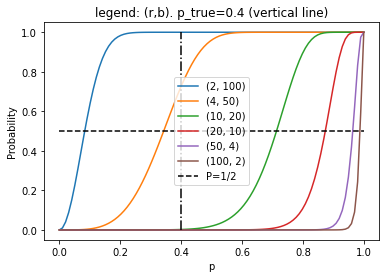

In [10]:
import matplotlib.pyplot as plt
n = 200
ops = [(2,100),(4,50),(10,20),(20,10),(50,4),(100,2)]
yval = lambda p,r,b: 1-(1-p**r)**b
pts = np.linspace(0,1,100)
yval(pts,.2,.2)
for op in ops:
    plt.plot(pts, yval(pts,op[0],op[1]), label=op)
plt.plot(pts,0*pts+0.5,'k--', label="P=1/2")
plt.plot([0.4,0.4],[0,1], 'k-.')
plt.legend()
plt.xlabel('p')
plt.ylabel('Probability')
plt.title("legend: (r,b). p_true=0.4 (vertical line)")
plt.show()

### 在调整 b,r 以保持 P=1/2 参数不变的情况下改变 n 的影响

现在我们来求解最佳值 $r,b$。

我们假设我们*固定*了 $n,r,b$。鉴于这些，我们确定哪一个近似点 $p$ 是交叉点。我们应该找到 $p=p(b,r)$。之后，我们就可以近似求解 $r,b$ 为所需的 $p$。

我们先从 $P=1/2$ 开始。

$$1/2 = 1-(1-p^r)^b$$
$$ 1-p^r = 2^{-1/b}$$
$$p = (1-2^{-1/b})^{1/r} = (1-e^{-(1/b)\ln2})^{1/r} \approx (1/b)^{1/r}*\text{const}$$

最后，如果我们固定 $r$ 和 $p$，我们可以发现所需的 band 约为
$$ b \approx 1/p^r$$

经验之谈：

增加 $r$ -> 
* 曲线向右移动；
* 更多的假阴性；
* 意味着更低的匹配机会。
                
增加 $b$ -> 
* 曲线向左移动；
* 更多的假阳性；
* 意味着更高的匹配机会。
                
增加 $n$ -> 
* 曲线接近一个阶梯函数；
* 更少的假任何东西；
* 总是好的!

现在看看当我们选择最佳的 $r,b$，然后增加 $n$ 时会发生什么。

我们将努力使 $p$ 保持在 $p=0.5$ 的中心位置。

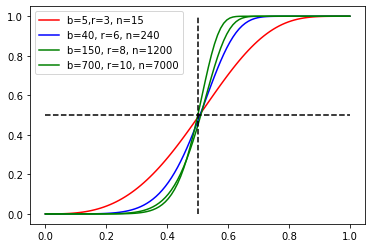

In [11]:
x = np.linspace(0,1,100)

b,r = 5, 3
y = 1-(1-x**r)**b
plt.plot(x,y,'r-',label=f"b={b},r={r}, n={b*r}")

b,r = 40, 6
y = 1-(1-x**r)**b
plt.plot(x,y,'b-',label=f"b={b}, r={r}, n={b*r}")

b,r = 150, 8
y = 1-(1-x**r)**b
plt.plot(x,y,'g-',label=f"b={b}, r={r}, n={b*r}")

b,r = 700, 10
y = 1-(1-x**r)**b
plt.plot(x,y,'g-',label=f"b={b}, r={r}, n={b*r}")


plt.plot(x,0*x+0.5,'k--')
plt.plot([0.5,0.5],[0,1],'k--')
plt.legend()
plt.show()

现在，我们用上述所有的方法来尝试优化我们之前的局部敏感哈希函数。

假设我们想要一个 $p=0.3$ 的阈值。我们可以计算出 band 数量的 $b\approx p^{-r}$。

对于 band 大小的前6个值，我们确定我们应该保持

$r=1 \to b=3,\,n=3$

$r=2 \to b=11,\,n=22$

$r=3 \to b=37,\,n=111$

$r=4 \to b=123,\,n=492$

$r=5 \to b=412,\,n=2060$

让我们试试中间的选择，使用四舍五入的数字 $n=120$，$b=40$，$r=3$。

让我们看看使用前面定义的函数，我们的结果有多好。我们首先需要构建用于签名矩阵的带状相似度量。将此放入一个函数

### 蛮力 band 候选对函数，用于以后检查哈希方法

In [12]:
def bandedCandidatePair(col1, col2, b, r):
    """Returns a boolean if the two columns are a candidate pair
    inputs must obey n=len(col1)=len(col2)=b*r"""
    n = len(col1)
    assert(n==b*r)
    assert(n==len(col2))
    truth_array = (col1==col2)
    return any(all(band) for band in np.array_split(truth_array,b))

def bandedCandidatePairs(sig_mat, b, r):
    d = sig_mat.shape[1]
    idxs = range(d)
    cols = [sig_mat[:,i] for i in range(d)]
    pairs = set()
    for (i,col1), (j,col2) in itertools.combinations(zip(idxs,cols),2):
        if bandedCandidatePair(col1,col2,b,r):
            pairs.add((i,j))
    return pairs

# set p = 0.3 arbitrarily
p = 0.3
n = 120
b = 30
r = 4

# see how many candidate pairs we got right!
sig_mat = hm(doc_shingles, n)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
print("True pairs:",candidatePairs(true_score_dict, p))
print("LSH pairs:",bandedCandidatePairs(sig_mat, b, r))
print("Vanilla MinHash pairs:",candidatePairs(approx_score_dict, p))
# accMatrix(true_score_dict, approx_score_dict, 0.4)

# sig_mat = hm(doc_shingles, n)
# true_score_dict = trueSimScores(doc_shingles)
printScoreComparison(true_score_dict, approx_score_dict)

True pairs: {(0, 4), (1, 4)}
LSH pairs: {(1, 4)}
Vanilla MinHash pairs: {(0, 4), (3, 4), (1, 4)}
**~~~~~~ Similarity score comparison ~~~~~~**
Pair		Approx		True		%Error
(0, 1)		0.150		0.050		200.71
(0, 2)		0.142		0.069		105.69
(0, 3)		0.175		0.093		87.70
(0, 4)		0.417		0.336		23.93
(1, 2)		0.167		0.052		222.44
(1, 3)		0.158		0.051		208.02
(1, 4)		0.450		0.400		12.45
(2, 3)		0.225		0.081		177.89
(2, 4)		0.267		0.083		221.40
(3, 4)		0.392		0.294		33.00


### 最后，我们使用一个 band 和列 ID 的哈希表，进行快速的候选对搜索

最后，我们将通过在 $\mathcal{O}(n)$ 时间内进行 band 对的比较来提高整个效率，而不是 $\mathcal{O}(n^2)$。

对于每一列的 band，我们将列索引的副本放入一个哈希表，键是行值。

例如，让 col=[4,2,5,6]。band 可能是 [(4,2),(5,6)]，我们将进入一个字典 d={(4,2):[col,...], (5,6):[col,...], ... }。

In [13]:
def fastCandidatePairs(sig_mat, b, r):
    n, d = sig_mat.shape
    assert(n==b*r)
    hashbuckets = collections.defaultdict(set)
    bands = np.array_split(sig_mat, b, axis=0)
    for i,band in enumerate(bands):
        for j in range(d):
            # The last value must be made a string, to prevent accidental
            # key collisions of r+1 integers when we really only want
            # keys of r integers plus a band index
            band_id = tuple(list(band[:,j])+[str(i)])
            hashbuckets[band_id].add(j)
    candidate_pairs = set()
    for bucket in hashbuckets.values():
        if len(bucket) > 1:
            for pair in itertools.combinations(bucket, 2):
                candidate_pairs.add(pair)
    return candidate_pairs


# to make sure it works, 
# compare with the brute force method on a few trials

# set p = 0.3 arbitrarily
p = 0.3
n = 120
b = 30
r = 4

# see how many candidate pairs we got right!
sig_mat = hm(doc_shingles, n)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
print('True pairs:\t', candidatePairs(true_score_dict, p))
print("True LSH pairs:\t", bandedCandidatePairs(sig_mat, b, r))
print("Fast LSH pairs:\t", fastCandidatePairs(sig_mat, b, r))
print("MinHash pairs:\t", candidatePairs(approx_score_dict, p))

True pairs:	 {(0, 4), (1, 4)}
True LSH pairs:	 {(3, 4)}
Fast LSH pairs:	 {(3, 4)}
MinHash pairs:	 {(2, 4), (0, 4), (3, 4), (1, 4)}


# Part II: 向量相似度

In [14]:
def cossim(u,v):
    norm = np.linalg.norm(u)*np.linalg.norm(v)
    cosine = u@v/norm
    ang = np.arccos(cosine)
    return 1-ang/np.pi

## 生成数据

我们创建 N 个维度为 D 的随机向量，然后重新分配其中的 5 个，使其人为地接近另一组 5 个。这是通过设置它们相等并添加少量的噪声来实现的。

通过人为地使一些向量与其他向量更接近，我们可以很容易地调整目标相似度阈值，使我们能够更好地进行实验。

In [15]:
# get some random data points
N = 1000
D= 50
A = np.random.randn(N,D)
# artificially make some similar to others
A[5] = A[99] +np.random.randn(D)*0.05
A[20] = A[85] +np.random.randn(D)*0.15
A[13] = A[19] +np.random.randn(D)*0.25
A[56] = A[71] +np.random.randn(D)*0.5
A[45] = A[49] +np.random.randn(D)*0.66

## 暴力计算基线

这是直接的。我们计算每一个可能的配对的余弦相似度，并只保留那些达到或超过所选阈值的配对

我们事先知道，最小的“人为最相似”的一对将是~0.82，所以我们将阈值设置为 0.8。

在实践中，设置阈值是一门艺术，取决于我们希望事物的真正相似程度。

In [16]:
true_pairs_dict = {}

thresh = 0.8

start = time.time()
for (i,u),(j,v) in itertools.combinations([(i,x) for i,x in enumerate(A)],2):
    val = cossim(u,v)
    if val > thresh:
        true_pairs_dict[(i,j)] = val
t_brute = time.time()-start

# save just the keys without the values. Easier to compare later to LSH
true_pairs = set(true_pairs_dict.keys())

print(f"Brute force calculation time: {t_brute:.3f}")
print(f"Discovered pairs:")
for k, v in true_pairs_dict.items():
    print(f"Pair: {k},\tSimilarity: {v:.2f}.")

Brute force calculation time: 5.855
Discovered pairs:
Pair: (5, 99),	Similarity: 0.98.
Pair: (13, 19),	Similarity: 0.91.
Pair: (20, 85),	Similarity: 0.96.
Pair: (56, 71),	Similarity: 0.86.


## 局部敏感哈希方法

### 寻找给定阈值的 r、b 参数

我们必须有 $D\%b==0$，也就是 band 的数量被维度整除。这是我们唯一的约束条件。记住，更高的 $n$ 总是更好的!

这里没有什么魔法，我们只是试错一些组合，直到我们接近所需的阈值，在这种情况下是0.75（在前面的单元格中选择）。

In [17]:
b, r = 50, 18

n = b*r
print(f"Transition probability: {(1/b)**(1/r):.2f}")

Transition probability: 0.80


### 计算 LSH 对

让 $S$ 为签名矩阵，$R$ 为随机超平面的矩阵。

在代码实现中，我们用我们方程的转置来工作。这意味着 $S=(N,D)$，因此我们必须在 axios=1 的范围内分成几个 band。

In [18]:
start = time.time()

# Compute signature matrix
R = A@np.random.randn(D,n)
S = np.where(R>0,1,0)

# Break into bands
S = np.split(S, b, axis=1)

# column vector to convert binary vector to integer e.g. (1,0,1)->5
binary_column = 2**np.arange(r).reshape(-1,1)

# convert each band into a single integer, 
# i.e. convert band matrices to band columns
S = np.hstack([M@binary_column for M in S])

# Every value in the matrix represents a hash bucket assignment
# For every bucket in row i, add index i to that bucket
d = collections.defaultdict(set)
with np.nditer(S,flags=['multi_index']) as it:
    for x in it:
        d[int(x)].add(it.multi_index[0])
        
# For every bucket, find all pairs. These are the LSH pairs.
candidate_pairs = set()
for k,v in d.items():
    if len(v) > 1:
        for pair in itertools.combinations(v,2):
            candidate_pairs.add(tuple(sorted(pair)))

# Finally, perform the actually similarity computation
# to weed out false positive
lsh_pairs = set()
for (i,j) in candidate_pairs:
    if cossim(A[i],A[j]) > thresh:
        lsh_pairs.add((i,j))
        
t_lsh = time.time()-start

print(f"LSH calculation time: {t_lsh:.3f}")

LSH calculation time: 0.109


## 比较这两种方法

上述情况应该表明，我们得到了大约25倍的速度，同时找到了所有的配对，而且没有假阴性！这是很有用的。

非常有用!

In [19]:
print(f"t_brute: {t_brute:.3f}\t t_lsh: {t_lsh:.3f}. Speed-up: {t_brute/t_lsh:.0f}x")
print("True pairs: ", true_pairs)
print("LSH pairs: ", lsh_pairs)
print(f"Candidate pairs: {len(candidate_pairs)}.\n\
False negatives: {len(true_pairs-lsh_pairs)}")

t_brute: 5.855	 t_lsh: 0.109. Speed-up: 54x
True pairs:  {(13, 19), (5, 99), (20, 85), (56, 71)}
LSH pairs:  {(56, 71), (5, 99), (20, 85), (13, 19)}
Candidate pairs: 4899.
False negatives: 0
